# Heroes Sesgados? (Mini Taller / Evaluación 8)

Los superhéroes y sus aventuras son parte de la cultura popular desde hace ya varias décadas. A pesar de que normalmente están dotados de habilidades fuera de lo ordinario (?), estos personajes suelen ser un reflejo de los valores y tradiciones del mundo en que vivimos, de modo que analizar sus historias y características puede arrojar conclusiones interesantes acerca de las dinámicas inconscientes que permean la sociedad. 

En este taller analizaremos datos para explorar eventuales **sesgos de género** que podrían existir en el mundo de los superhéroes.


![texto alternativo](https://static.comicvine.com/uploads/original/11132/111329943/5990590-2478258-jl__11___page_16.jpg)



## Datos
 
Los datos con los que trabajará corresponden a una *muestra* de superhéroes extraídos de la base de datos *superherodb.com*, considerando sólo aquellos cuentan con descripciones suficientes para un análisis. El archivo *heroes_with_powers.csv* contiene información sobre los atributos físicos del personaje como raza, color de piel, color de ojos y género. Esta información fue cruzada con información cuantitativa sobre las habilidades del superhéroe, reducidas a 6 grandes categorías

> 'Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat'

 Si les interesa, hay un dataset más detallado de habiidades en 'hero_pow_binary.csv', pero es binario y acá no lo usaremos.

Me esperaba una presencia más clara de géneros no-binarios o fluidos entre los supehéroes, pero domina la clasificación tradicional 'Male' - 'Female'. Hay 26 personajes sin clasificación, que se asumirán *NB* (non-binary). Una investigación más profunda quedará para el futuro.

Los superhéroes también se encuentran clasificados en términos de alineamiento valórico (columna 'Alignment'):

> bad, good, neutral

Se asumirá que "good" representa una predisposición al altruismo, el respeto por la vida, y la preocupación por la dignidad de los seres sensientes. 

Si lo desean, pueden encontrar más información sobre el dataset en *Kaggle*, una comunidad dedicada a la *ciencia de datos* y *machine learning*. https://www.kaggle.com

**Para facilitar su trabajo, los datos que necesita para cada actividad están disponibles en la sección "Desarrollo" indicando el número de la pregunta.**

In [37]:
#Si carga los datos localmente no necesita ejecutar esta celda.
#Si los carga desde Drive, debe cambiar la ruta a la carpeta donde se encuentran. 

print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=False)
 
path = "/content/drive/My Drive/Colab Notebooks/"#Esta es la ruta


Mounting your Google Drive ...
Mounted at /content/drive


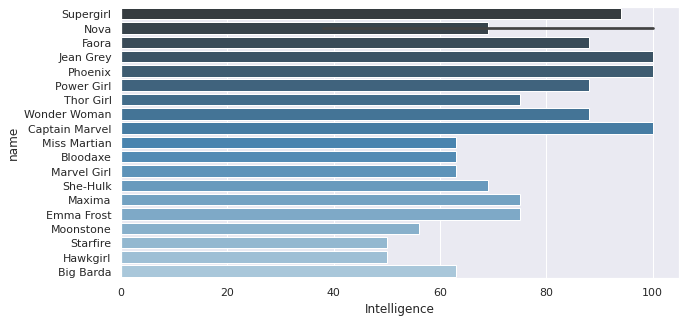

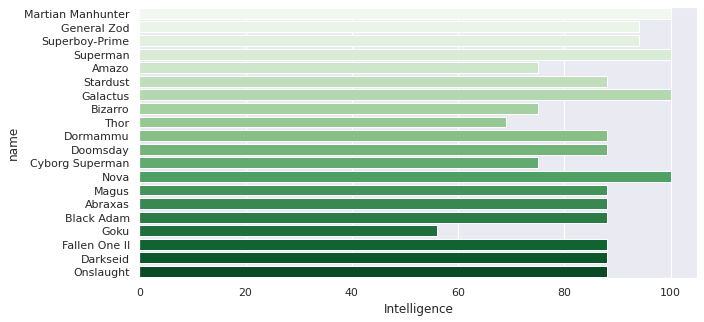

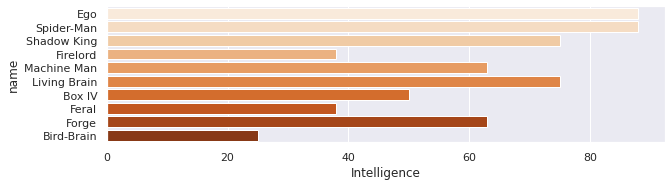

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

heroes_df = pd.read_csv(path+'heroes_with_powers.csv')
heroes_df.loc[(heroes_df.Gender != 'Female') & (heroes_df.Gender != 'Male'),'Gender'] = 'NB'
habilidades = ['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']
sorted_df = heroes_df.iloc[heroes_df[habilidades].mean(axis=1).argsort()[::-1]]
sorted_df_w = sorted_df[sorted_df.Gender=='Female'].iloc[:20]
sorted_df_h = sorted_df[sorted_df.Gender=='Male'].iloc[:20]
sorted_df_nb = sorted_df[sorted_df.Gender=='NB'].iloc[:10]

fig, ax = plt.subplots(figsize=(10,5),nrows=1, sharey=True)
sns.barplot(data=sorted_df_w, x='Intelligence', y='name', palette="Blues_d",ax=ax)
fig, ax = plt.subplots(figsize=(10,5),nrows=1, sharey=True)
sns.barplot(data=sorted_df_h, x='Intelligence', y='name', palette="Greens", ax=ax)
fig, ax = plt.subplots(figsize=(10,2.5),nrows=1, sharey=True)
sns.barplot(data=sorted_df_nb, x='Intelligence', y='name', palette='Oranges', ax=ax)
plt.show()

## Funciones de Ayuda

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.stats import f as fisher

#H0: mu1 = mu0 (mu1 desconocida, m0 valor fijo)
def contrate_1media(n1,media1,std1,mu0,error_tipo1,alternativa='1>0'):
  region_critica = []
  gl = n1-1
  std_error = np.sqrt(std1**2/n1)
  T0 = (media1-mu0)/std_error#estadistico bajo H0
  if (alternativa=='1>0'):
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1,df=gl), right=np.inf,closed='neither'))
    p_value = 1-t.cdf(T0,df=gl)
  elif (alternativa=='1<0'):
    region_critica.append(pd.Interval(left=-np.inf, right=t.ppf(error_tipo1,df=gl),closed='neither'))
    p_value = t.cdf(T0,df=gl)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=t.ppf(error_tipo1/2,df=gl),closed='neither'))
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1/2,df=gl),right=np.inf,closed='neither'))
    p_value = 2*min(1-t.cdf(T0,df=gl),t.cdf(T0,df=gl))
  return T0, region_critica, p_value


#H0: mu1 = mu2 (mu1,mu2 ambas no conocidas)
def contrate_2medias(n1,n2,media1,media2,std1,std2,error_tipo1,alternativa='1>2'):
  region_critica = []
  gl_num = (std1**2/float(n1) + std2**2/float(n2))**2
  gl_den = ((std1**2/float(n1))**2)/(n1-1.0) + ((std2**2/float(n2))**2)/(n2-1.0)
  gl = int(np.floor(gl_num/gl_den))
  std_error = np.sqrt(std1**2/n1 + std2**2/n2)
  T0 = (media1-media2)/std_error#estadistico bajo H0
  if (alternativa=='1>2'):
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1,df=gl), right=np.inf,closed='neither'))
    p_value = 1-t.cdf(T0,df=gl)
  elif (alternativa=='1<2'):
    region_critica.append(pd.Interval(left=-np.inf, right=t.ppf(error_tipo1,df=gl),closed='neither'))
    p_value = t.cdf(T0,df=gl)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=t.ppf(error_tipo1/2,df=gl),closed='neither'))
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1/2,df=gl),right=np.inf,closed='neither'))
    p_value = 2*min(1-t.cdf(T0,df=gl),t.cdf(T0,df=gl))
  return T0, region_critica, p_value

#H0: sigma1 = sigma2 (sigma1,sigma2 ambas no conocidas)
def contrate_dos_varianzas(n1,n2,std1,std2,error_tipo1,alternativa='1>2'):
  region_critica = []
  F0 = std1**2/std2**2
  if (alternativa=='1>2'):
    region_critica.append(pd.Interval(left=fisher.ppf(1-error_tipo1,dfn=n1-1, dfd=n2-1), right=np.inf,closed='neither'))
    p_value = 1-fisher.cdf(F0,dfn=n1-1, dfd=n2-1)
  elif (alternativa=='1<2'):
    region_critica.append(pd.Interval(left=-np.inf, right=fisher.ppf(error_tipo1,dfn=n1-1, dfd=n2-1),closed='neither'))
    p_value = fisher.cdf(F0,dfn=n1-1, dfd=n2-1)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=fisher.ppf(error_tipo1/2,dfn=n1-1, dfd=n2-1),closed='neither'))
    region_critica.append(pd.Interval(left=fisher.ppf(1-error_tipo1/2,dfn=n1-1, dfd=n2-1),right=np.inf,closed='neither'))
    p_value = 2*min(1-fisher.cdf(F0,dfn=n1-1, dfd=n2-1),fisher.cdf(F0,dfn=n1-1, dfd=n2-1))
  return F0, region_critica, p_value


#H0: p1 = p0 (p1 desconocida, p0 valor fijo)
def contrate_1prop(n1,prop1,p0,error_tipo1,alternativa='1>0'):
  region_critica = []
  std_error = np.sqrt(p0*(1.0-p0))*np.sqrt(1.0/n1)
  Z0 = (prop1-p0)/std_error
  if (alternativa=='1>0'):
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1), right=np.inf,closed='neither'))
    p_value = 1-norm.cdf(Z0)
  elif (alternativa=='1<0'):
    region_critica.append(pd.Interval(left=-np.inf, right=norm.ppf(error_tipo1),closed='neither'))
    p_value = norm.cdf(Z0)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=norm.ppf(error_tipo1/2),closed='neither'))
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1/2),right=np.inf,closed='neither'))
    print(">>",Z0,1-norm.cdf(Z0),norm.cdf(Z0))
    p_value = 2*min(1-norm.cdf(Z0),norm.cdf(Z0))
  return Z0, region_critica, p_value

#H0: p1 = p2 (p1,p2 no conocidas, ni funcion una de la otra)
def contrate_2props(n1,n2,prop1,prop2,error_tipo1,alternativa='1>2'):
  region_critica = []
  prop_comb = (n1*prop1 + n2*prop2)/(n1+n2)
  std_error = np.sqrt(prop_comb*(1.0-prop_comb))*np.sqrt(1.0/n1 + 1.0/n2)
  Z0 = (prop1-prop2)/std_error

  if (alternativa=='1>2'):
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1), right=np.inf,closed='neither'))
    p_value = 1-norm.cdf(Z0)
  elif (alternativa=='1<2'):
    region_critica.append(pd.Interval(left=-np.inf, right=norm.ppf(error_tipo1),closed='neither'))
    p_value = norm.cdf(Z0)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=norm.ppf(error_tipo1/2),closed='neither'))
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1/2),right=np.inf,closed='neither'))
    print(">>",Z0,1-norm.cdf(Z0),norm.cdf(Z0))
    p_value = 2*min(1-norm.cdf(Z0),norm.cdf(Z0))
  return Z0, region_critica, p_value


## Preguntas



**Al abordar las siguientes preguntas por favor indique claramente cuál es $H_0$, $H_1$, el estadístico de contraste y la región crítica.**





1.   Diseñe un contraste que permita evaluar la hipótesis de que *la proporción de personajes de género femenino en la población de super-héroes es menor al 30%*. Diseñe su contraste de manera que la probabilidad de aceptar incorrectamente esta conjetura es menor al 10%. Determine luego el tamaño mínimo que se puede adoptar en el contraste para aceptar la hipótesis alternativa (p-valor). Comente sobre significado del resultado.

2.   Diseñe un contraste que permita establecer si la proporción de personajes masculinos y femeninos difiere significativamente en la población de super-héroes. Determine el tamaño mínimo que se puede adoptar en el contraste para aceptar la hipótesis alternativa (p-valor). Comente el resultado.

3.  Diseñe un contraste que le permita determinar si el valor esperado de la habilidad de un super-héroe es igual entre personajes de diferentes géneros. Considere los casos Male-Female y Male-NB. Evalue su contraste (el mismo) para cada una de las 6 habilidades, adoptando un nivel de significación del 5%. 

4. Diseñe un contraste que le permita evaluar la hipótesis H de que la habilidad de un super-héroe femenino es mayor entre personajes con orientación hacia el mal. Evalue su contraste para cada una de las 6 habilidades, eligiendo la región crítica de modo que la probabilidad de aceptar incorrectamente la hipótesis sea menor al 5%.



In [40]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

heroes_df = pd.read_csv(path+'heroes_with_powers.csv')
heroes_df.loc[(heroes_df.Gender != 'Female') & (heroes_df.Gender != 'Male'),'Gender'] = 'NB'
heroes_HOMBRE = heroes_df[heroes_df.Gender == 'Male'].copy()
heroes_MUJER = heroes_df[heroes_df.Gender == 'Female'].copy()
heroes_NB = heroes_df[heroes_df.Gender == 'NB'].copy()

#PREGUNTAS 1, 2
N_HOMBRE = len(heroes_HOMBRE)#numero total de hombres
N_MUJER = len(heroes_MUJER)#numero total de mujeres
N_NB = len(heroes_NB)#numero total de NB

#PREGUNTA 3
print("\nPREGUNTA 3 ...\n")
habilidades = ['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']
for idx,habilidad in enumerate(habilidades):

  VALORES_HOMBRES = heroes_HOMBRE.loc[heroes_HOMBRE[habilidad]!=1,habilidad].dropna() #1 es desconocido, eliminar
  VALORES_MUJERES = heroes_MUJER.loc[heroes_MUJER[habilidad]!=1,habilidad].dropna()#1 es desconocido, eliminar
  VALORES_NB = heroes_NB.loc[heroes_NB[habilidad]!=1,habilidad].dropna()#1 es desconocido, eliminar

  PROMEDIO_HOMBRES = VALORES_HOMBRES.values.mean()
  PROMEDIO_MUJERES = VALORES_MUJERES.values.mean()
  PROMEDIO_NB = VALORES_NB.values.mean()

  S2_HOMBRES = VALORES_HOMBRES.values.std(ddof=1)#varianza muestral
  S2_MUJERES = VALORES_MUJERES.values.std(ddof=1)
  S2_NB = VALORES_NB.values.std(ddof=0)

  N_HOMBRES = len(VALORES_HOMBRES)
  N_MUJERES = len(VALORES_MUJERES)
  N_NB = len(VALORES_NB)

  print(habilidad,"Hombres, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_HOMBRES,S2_HOMBRES,N_HOMBRES))
  print(habilidad,"Mujeres, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_MUJERES,S2_MUJERES,N_MUJERES))
  print(habilidad,"NB, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_NB,S2_NB,N_NB))
  print(" ")

#PREGUNTA 4
print("\nPREGUNTA 4 ...\n")
habilidades = ['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']
gender_analizar = 'Female'
for idx,habilidad in enumerate(habilidades):

  VALORES_HEROES = heroes_df.loc[(heroes_df['Gender']==gender_analizar) & (heroes_df[habilidad]!=1) & (heroes_df['Alignment']=='good'),habilidad].dropna()#1 es desconocido, eliminar
  VALORES_VILLANOS = heroes_df.loc[(heroes_df['Gender']==gender_analizar) & (heroes_df[habilidad]!=1) & (heroes_df['Alignment']=='bad'),habilidad].dropna()#1 es desconocido, eliminar
  
  PROMEDIO_HEROES = VALORES_HEROES.values.mean()
  PROMEDIO_VILANOS = VALORES_VILLANOS.values.mean()

  S_HEROES = VALORES_HEROES.values.std(ddof=1)
  S_VILANOS = VALORES_VILLANOS.values.std(ddof=1)

  N_HEROES = len(VALORES_HEROES)
  N_VILLANOS = len(VALORES_VILLANOS)

  print(habilidad,gender_analizar,"Villanos, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_VILANOS,S_VILANOS,N_VILLANOS))
  print(habilidad,gender_analizar,"Heroes, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_HEROES,S_HEROES,N_HEROES))

  print(" ")



PREGUNTA 3 ...

Intelligence Hombres, Media=64.16, S2=21.56, N=308
Intelligence Mujeres, Media=60.40, S2=17.09, N=111
Intelligence NB, Media=58.27, S2=20.85, N=11
 
Strength Hombres, Media=43.96, S2=32.57, N=309
Strength Mujeres, Media=34.33, S2=31.44, N=111
Strength NB, Media=38.91, S2=25.98, N=11
 
Speed Hombres, Media=40.09, S2=24.28, N=308
Speed Mujeres, Media=34.49, S2=19.23, N=111
Speed NB, Media=43.00, S2=21.74, N=10
 
Durability Hombres, Media=63.41, S2=29.74, N=307
Durability Mujeres, Media=50.00, S2=29.25, N=111
Durability NB, Media=61.50, S2=29.80, N=10
 
Power Hombres, Media=43.83, S2=35.81, N=415
Power Mujeres, Media=37.83, S2=31.30, N=160
Power NB, Media=17.62, S2=27.33, N=24
 
Combat Hombres, Media=62.33, S2=23.06, N=308
Combat Mujeres, Media=57.68, S2=21.94, N=111
Combat NB, Media=48.55, S2=22.52, N=11
 

PREGUNTA 4 ...

Intelligence Female Villanos, Media=63.35, S2=16.85, N=20
Intelligence Female Heroes, Media=59.86, S2=17.23, N=90
 
Strength Female Villanos, Media=40

#Desarrollo#

##Pregunta 1##
> Para esta pregunta, las hipótesis propuestas son las siguientes:

> *   $H_0$ : $P_{femenino} = $ 30%
> *   $H_1$ : $P_{femenino} < $ 30%

> Utilizaremos un contraste para una proporción, entonces:

In [52]:
total_heroes = N_MUJER+N_NB+N_HOMBRE
prop_mujeres = N_MUJER/total_heroes #proporcion de mujeres respecto al total
print("La proporción de mujeres respecto al total de héroes es de: %.2f (n = %.d)" % (prop_mujeres,N_MUJER))
alpha = 0.1

Z0, region_critica, p_value = contrate_1prop(total_heroes,prop_mujeres,0.3,error_tipo1=alpha,alternativa='1<0')

result = "Pfemenina < 30% (Rechazamos H_0)" if np.any([Z0 in region for region in region_critica]) else "Pfemenina = 30%"

print("Estadístico:",Z0,"Región Crítica:",[str(region) for region in region_critica])
print("Decisión:", result,"p-value:",p_value)
print("----")


La proporción de mujeres respecto al total de héroes es de: 0.27 (n = 160)
Estadístico: -1.4500974139476064 Región Crítica: ['(-inf, -1.2815515655446004)']
Decisión: Pfemenina < 30% (Rechazamos H_0) p-value: 0.07351567808699454
----


> Notemos que, para un nivel de significación de $\alpha=0.1$, nuestro estadístico $Z_0 \approx -1.46$ es menor al percentil $Z_{1-\alpha} \approx -1.28$ (Región Crítica $=\left(-\infty, -1.28\right)$) que acumula probabilidad $\alpha$. Por lo tanto, optamos por rechazar a $H_0$ y por no rechazar a $H_1$. Los contrastes. en general, están diseñados para que sea dificil rechazar $H_0$, si el p-valor es muy pequeño, significa que hay fuerte evidencia en contra $H_0$. En este caso, el p-valor toma un valor de $\alpha \approx 0.07$, el cual es un valor no tan significante estadísticamente hablando, es decir, si aumentamos el alfa hasta el p-valor, vamos a obtener, en efecto, que la poblacion femenina si es del 30%, y por lo tanto, a ese nivel de significancia, optamos por no rechazar $H_0$ y rechazar $H_1$.



##Pregunta 2##
> Para esta pregunta, las hipótesis propuestas son las siguientes:

> *   $H_0$ : $P_{masculino} = P_{femenino}$
> *   $H_1$ : $P_{masculino} \neq P_{femenino}$

> Utilizaremos un contraste de hipótesis para dos proporciones, entonces:

In [57]:
total_heroes = N_MUJER+N_NB+N_HOMBRE
prop_hombres = N_HOMBRE/total_heroes #proporcion de hombres respecto al total
prop_mujeres = N_MUJER/total_heroes #proporcion de mujeres respecto al total
print("La proporción de hombres respecto al total de héroes es de: %.2f (n = %.d)" % (prop_hombres,N_HOMBRE))
print("La proporción de mujeres respecto al total de héroes es de: %.2f (n = %.d)" % (prop_mujeres,N_MUJER))
alpha = 0.1

Z0, region_critica, p_value = contrate_2props(total_heroes,total_heroes,prop_hombres,prop_mujeres,error_tipo1=alpha,alternativa='2 colas')

result = "Pmasculina != Pfemenina" if np.any([Z0 in region for region in region_critica]) else "No podemos rechazar Pmasculina = Pfemenina"

print("Estadístico:",Z0,"Región Crítica:",[str(region) for region in region_critica])
print("Decisión:", result,"p-value:",p_value)
print("----")

La proporción de hombres respecto al total de héroes es de: 0.71 (n = 416)
La proporción de mujeres respecto al total de héroes es de: 0.27 (n = 160)
>> 14.945559575403154 0.0 1.0
Estadístico: 14.945559575403154 Región Crítica: ['(-inf, -1.6448536269514729)', '(1.6448536269514722, inf)']
Decisión: Pmasculina != Pfemenina p-value: 0.0
----


> Utilizando un nivel de significación de $\alpha=0.1$, notemos que nuestro estadístico $Z_0 \approx 14.95$ es mucho mayor al percentil $Z_{\alpha/2} \approx 1.64$ (Región Crítica :$\left(-\infty, -1.64\right) \cup \left(1.64, \infty\right)$ ) que acumula probabilidad $1-\alpha/2$. Por lo tanto, optamos por rechazar a $H_0$ y por no rechazar a $H_1$. Notemos que, nuestro p-value es 0 porque el valor del estadistico es extremadamente alto, y por lo tanto, muy alejado de los límites de intervalo. Además, notar que, dadas las muestras, existen todas las evidencias para poder rechazar con certeza nuestra $H_0$ propuesta, es decir, podemos seguir bajando nuestro nivel de significancia a valores ínfimos y aún así seguir rechazando $H_0$.


##Pregunta 3##
> Para esta pregunta, las hipótesis propuestas son las siguientes:

> *   $H_0$ : $\mu_{femenino} = \mu_{x}$
> *   $H_1$ : $\mu_{femenino} \neq \mu_{x}$

> En donde $\mu_{x}$ denota cualquiera de los otros dos géneros que no son femenino, es decir, masculino y no-binario.

> Utilizaremos un contraste de hipótesis para dos medias para cada habilidad de los superhéroes, entonces:

In [43]:
#femenino v/s masculino

habilidades = ['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']
for idx,habilidad in enumerate(habilidades):
    VALORES_MUJERES = heroes_MUJER.loc[heroes_MUJER[habilidad]!=1,habilidad].dropna()#1 es desconocido, eliminar
    VALORES_HOMBRES = heroes_HOMBRE.loc[heroes_HOMBRE[habilidad]!=1,habilidad].dropna() #1 es desconocido, eliminar

    PROMEDIO_MUJERES = VALORES_MUJERES.values.mean()
    PROMEDIO_HOMBRES = VALORES_HOMBRES.values.mean()

    S2_MUJERES = VALORES_MUJERES.values.std(ddof=1)
    S2_HOMBRES = VALORES_HOMBRES.values.std(ddof=1)#varianza muestral

    N_MUJERES = len(VALORES_MUJERES)
    N_HOMBRES = len(VALORES_HOMBRES)

    print(habilidad,"Hombres, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_HOMBRES,S2_HOMBRES,N_HOMBRES))
    print(habilidad,"Mujeres, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_MUJERES,S2_MUJERES,N_MUJERES))
    print(" ")

    #acá comenzamos a realizar los test de hipótesis
    alpha = 0.05

    T0, region_critica, p_value = contrate_2medias(N_MUJERES,N_HOMBRES,PROMEDIO_MUJERES,PROMEDIO_HOMBRES,S2_MUJERES,S2_HOMBRES,error_tipo1=alpha,alternativa='2 colas')

    result = "Mu_femenino != Mu_masculino" if np.any([T0 in region for region in region_critica]) else "No podemos rechazar Mu_femenino = Mu_masculino"

    print("Estadístico:",T0,"Región Crítica:",[str(region) for region in region_critica])
    print("Decisión:", result,"p-value:",p_value)
    print("----")

Intelligence Hombres, Media=64.16, S2=21.56, N=308
Intelligence Mujeres, Media=60.40, S2=17.09, N=111
 
Estadístico: -1.849131053692617 Región Crítica: ['(-inf, -1.9697743954258797)', '(1.9697743954258793, inf)']
Decisión: No podemos rechazar Mu_femenino = Mu_masculino p-value: 0.0656534004285808
----
Strength Hombres, Media=43.96, S2=32.57, N=309
Strength Mujeres, Media=34.33, S2=31.44, N=111
 
Estadístico: -2.742050467942013 Región Crítica: ['(-inf, -1.9718962236316093)', '(1.9718962236316089, inf)']
Decisión: Mu_femenino != Mu_masculino p-value: 0.006659512785193435
----
Speed Hombres, Media=40.09, S2=24.28, N=308
Speed Mujeres, Media=34.49, S2=19.23, N=111
 
Estadístico: -2.445353590976331 Región Crítica: ['(-inf, -1.9697743954258797)', '(1.9697743954258793, inf)']
Decisión: Mu_femenino != Mu_masculino p-value: 0.01518180513593934
----
Durability Hombres, Media=63.41, S2=29.74, N=307
Durability Mujeres, Media=50.00, S2=29.25, N=111
 
Estadístico: -4.122647342215886 Región Crítica: 

In [44]:
#femenino v/s no-binario

habilidades = ['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']
for idx,habilidad in enumerate(habilidades):
    VALORES_MUJERES = heroes_MUJER.loc[heroes_MUJER[habilidad]!=1,habilidad].dropna()#1 es desconocido, eliminar
    VALORES_NB = heroes_NB.loc[heroes_NB[habilidad]!=1,habilidad].dropna()#1 es desconocido, eliminar

    PROMEDIO_MUJERES = VALORES_MUJERES.values.mean()
    PROMEDIO_NB = VALORES_NB.values.mean()

    S2_MUJERES = VALORES_MUJERES.values.std(ddof=1)
    S2_NB = VALORES_NB.values.std(ddof=0)

    N_MUJERES = len(VALORES_MUJERES)
    N_NB = len(VALORES_NB)

    print(habilidad,"Mujeres, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_MUJERES,S2_MUJERES,N_MUJERES))
    print(habilidad,"NB, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_NB,S2_NB,N_NB))
    print(" ")

    #acá comenzamos a realizar los test de hipótesis
    alpha = 0.05

    T0, region_critica, p_value = contrate_2medias(N_MUJERES,N_NB,PROMEDIO_MUJERES,PROMEDIO_NB,S2_MUJERES,S2_NB,error_tipo1=alpha,alternativa='2 colas')

    result = "Mu_femenino != Mu_no-binario" if np.any([T0 in region for region in region_critica]) else "No podemos rechazar Mu_femenino = Mu_no-binario"

    print("Estadístico:",T0,"Región Crítica:",[str(region) for region in region_critica])
    print("Decisión:", result,"p-value:",p_value)
    print("----")

Intelligence Mujeres, Media=60.40, S2=17.09, N=111
Intelligence NB, Media=58.27, S2=20.85, N=11
 
Estadístico: 0.32715688452531494 Región Crítica: ['(-inf, -2.200985160082949)', '(2.200985160082949, inf)']
Decisión: No podemos rechazar Mu_femenino = Mu_no-binario p-value: 0.7496905075861127
----
Strength Mujeres, Media=34.33, S2=31.44, N=111
Strength NB, Media=38.91, S2=25.98, N=11
 
Estadístico: -0.5458023002241468 Región Crítica: ['(-inf, -2.160368656461013)', '(2.1603686564610127, inf)']
Decisión: No podemos rechazar Mu_femenino = Mu_no-binario p-value: 0.594444365197559
----
Speed Mujeres, Media=34.49, S2=19.23, N=111
Speed NB, Media=43.00, S2=21.74, N=10
 
Estadístico: -1.1969160313643668 Región Crítica: ['(-inf, -2.2281388519649385)', '(2.2281388519649385, inf)']
Decisión: No podemos rechazar Mu_femenino = Mu_no-binario p-value: 0.25894350257138626
----
Durability Mujeres, Media=50.00, S2=29.25, N=111
Durability NB, Media=61.50, S2=29.80, N=10
 
Estadístico: -1.1704833022876076 R

> Utilizando ahora un nivel de significación de $\alpha=0.05$, notemos que:
> ### Para $\mu_{femenino}$ v/s $\mu_{masculino}$ ###
>> Nuestro estadístico $T_0$ cae en la región crítica en las habilidades:
*   **Strength (Fuerza)** $\Rightarrow$ $T_0 = -2.74$ $\in$ Región Crítica $\left(-\infty, -1.97\right) \cup \left(1.97, \infty\right)$, con $p_{value} \approx 0.0066$   
*   **Speed (Velocidad)**  $\Rightarrow$  $T_0 = -2.44$ $\in$ Región Crítica $\left(-\infty, -1.96\right) \cup \left(1.96, \infty\right)$, con $p_{value} \approx 0.015$      
*   **Durability (Durabilidad o Resistencia (?))** $\Rightarrow$  $T_0 = -4.12$ $\in$ Región Crítica $\left(-\infty, -1.97\right) \cup \left(1.97, \infty\right)$, con $p_{value} \approx 0.00005517$      
*   **Power (Poder)**  $\Rightarrow$ $T_0 = -1.97$ $\in$ Región Crítica $\left(-\infty, -1.96\right) \cup \left(1.96, \infty\right)$, con $p_{value} \approx 0.048$      









> ### Para $\mu_{femenino}$ v/s $\mu_{no-binario}$ ###
>> Nuestro estadístico $T_0$ cae en la región crítica solamente en la habilidad:
*   **Power (Poder)** $\Rightarrow$ $T_0 = 3.31$ $\in$ Región Crítica $\left(-\infty, -2.03\right) \cup \left(2.03, \infty\right)$, con $p_{value} \approx 0.0023$   



> Notemos que, para un nivel de significancia de $\alpha = 0.05$ existe una fuerte brecha entre las habilidades de las del género femenino v/s masculino, esto debido a la cantidad de estadísticas $T_0$ que se encuentran en la región crítica de las habilidades, no así como en la comparación de habilidades entre géneros femenino v/s no-binario, en donde nuestro estadístico de contraste $T_0$ cae en la región crítica en una sola habilidad. No obstante, notemos también que éstos resultados no son tan representativos del todo, especialmente en los casos del género no-binario, debido a la poca cantidad de datos de la muestra que se extrajeron para realizar los análisis.

##Pregunta 4##
> Para esta pregunta, las hipótesis propuestas son las siguientes:

> *   $H_0$ : $\mu_{heroina} = \mu_{villana}$
> *   $H_1$ : $\mu_{villana} > \mu_{heroina}$

> Utilizaremos un contraste de hipótesis para dos medias para cada habilidad de los superhéroes, entonces:

In [59]:
#femenino heroe v/s femenino villano

habilidades = ['Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat']
gender_analizar = 'Female'
for idx,habilidad in enumerate(habilidades):
    VALORES_HEROES = heroes_df.loc[(heroes_df['Gender']==gender_analizar) & (heroes_df[habilidad]!=1) & (heroes_df['Alignment']=='good'),habilidad].dropna()#1 es desconocido, eliminar
    VALORES_VILLANOS = heroes_df.loc[(heroes_df['Gender']==gender_analizar) & (heroes_df[habilidad]!=1) & (heroes_df['Alignment']=='bad'),habilidad].dropna()#1 es desconocido, eliminar
    
    PROMEDIO_HEROES = VALORES_HEROES.values.mean()
    PROMEDIO_VILANOS = VALORES_VILLANOS.values.mean()

    S_HEROES = VALORES_HEROES.values.std(ddof=1)
    S_VILANOS = VALORES_VILLANOS.values.std(ddof=1)

    N_HEROES = len(VALORES_HEROES)
    N_VILLANOS = len(VALORES_VILLANOS)

    print(habilidad,gender_analizar,"Villanos, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_VILANOS,S_VILANOS,N_VILLANOS))
    print(habilidad,gender_analizar,"Heroes, Media=%.2f, S2=%.2f, N=%d"%(PROMEDIO_HEROES,S_HEROES,N_HEROES))

    print(" ")

    #acá comenzamos a realizar los test de hipótesis
    alpha = 0.05

    T0, region_critica, p_value = contrate_2medias(N_HEROES,N_VILLANOS,PROMEDIO_HEROES,PROMEDIO_VILANOS,S_HEROES,S_VILANOS,error_tipo1=alpha,alternativa='1>2')

    result = "Mu_villanas > Mu_heroínas" if np.any([T0 in region for region in region_critica]) else "No podemos rechazar Mu_heroínas = Mu_villanas"

    print("Estadístico:",T0,"Región Crítica:",[str(region) for region in region_critica])
    print("Decisión:", result,"p-value:",p_value)
    print("----")


Intelligence Female Villanos, Media=63.35, S2=16.85, N=20
Intelligence Female Heroes, Media=59.86, S2=17.23, N=90
 
Estadístico: -0.835452522723083 Región Crítica: ['(1.701130934265931, inf)']
Decisión: No podemos rechazar Mu_heroínas = Mu_villanas p-value: 0.7947322174577796
----
Strength Female Villanos, Media=40.60, S2=34.45, N=20
Strength Female Heroes, Media=33.21, S2=30.85, N=90
 
Estadístico: -0.8836707475646581 Región Crítica: ['(1.7056179197592727, inf)']
Decisión: No podemos rechazar Mu_heroínas = Mu_villanas p-value: 0.807513800760335
----
Speed Female Villanos, Media=30.15, S2=14.45, N=20
Speed Female Heroes, Media=35.51, S2=20.18, N=90
 
Estadístico: 1.3857946639988528 Región Crítica: ['(1.6870936167109873, inf)']
Decisión: No podemos rechazar Mu_heroínas = Mu_villanas p-value: 0.08705308408305967
----
Durability Female Villanos, Media=50.70, S2=26.64, N=20
Durability Female Heroes, Media=49.62, S2=30.01, N=90
 
Estadístico: -0.15977225152406851 Región Crítica: ['(1.697260

> En este caso de test de hipótesis , para la comparación de heroínas v/s villanas, notemos que nuestro estadístico $T_0$ a evaluar no cayó en ninguna región crítica de las habilidades, lo que nos da a entender que las diferencias entre habilidades de heroínas y villanas no difieren mayormente, esto probado para un nivel de significancia de $\alpha = 0.05$. Teniendo lo anterior en cuenta, podemos rescatar que, entre heroínas y villanas, no hay mayor discriminación entre la cantidad de puntos que tengan en cada habilidad, dado se tratan de manera similar y justa. Entonces, concluimos que no hay evidencia suficiente para descartar la hipótesis nula, es decir, optamos por no rechazar $H_0$ y rechazar $H_1$. 

#Conclusiones#

> Mediante los contrastes de hipótesis realizados sobre las muestras de superhéroes, encontramos que hay una sesgo fuertemente marcado entre las habilidades de los héroes de género femenino v/s género masculino, especialmente en las habilidades físicas de éstos, tales como *Fuerza*, *Velocidad*, etc., y esto para valores de nivel de significancia bastante bajos, y por lo tanto, **estadísticamente significativos**. Sin embargo, encontramos también que, comparando las habilidades de los héroes de género femenino v/s género no-binario, no hubo mayores diferencias.

> Comparando además las habilidades de heroínas v/s villanas, no se encontraron mayores diferencias entre las muestras entregadas, es decir, era una repartición equitativa en la distribución de habilidades y superpoderes de los personajes femeninos, entonces, podemos rescatar que no discriminan entre personajes del mismo género (en este caso femenino), no así como en las habilidades en la comparación mujeres v/s hombres, en donde sí se halló claramente un sesgo significativo entre las habilidades.

[texto del enlace](https://)